In [13]:
# %load datasets.py
import os
import ssl
import wget
import zipfile

import numpy as np
import pandas as pd


def download_and_prepare(name, path):
    if not os.path.exists(path):
        os.makedirs(path)
    if name == "movielens-small":
        print(f"Preparing dataset {name}...")
        # Check if data has been extracted and if not download extract it
        if (os.path.exists(os.path.join(path, "ml-latest-small"))):
            print(f"Dataset {name} already extracted.")
        else:
            print(f"Downloading dataset {name}...")
            ssl._create_default_https_context = ssl._create_unverified_context
            url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
            wget.download(url, os.path.join(path, "ml-latest-small.zip"))
            print(f"Extracting dataset {name}...")
            with zipfile.ZipFile(os.path.join(path, "ml-latest-small.zip"), 'r') as zip_ref:
                zip_ref.extractall(path)

        # Read dataset with pandas
        ratings = pd.read_csv(os.path.join(path, 'ml-latest-small', 'ratings.csv'))
        print(f"{len(ratings)} entries read.")
        r_matrix = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)

        return np.array(r_matrix) # for performance reasons we only take every 2nd element along each axis

    else:
        raise ValueError


Preparing dataset movielens-small...
Dataset movielens-small already extracted.
100836 entries read.
(610, 9724)
(610, 9724)
122.0
0


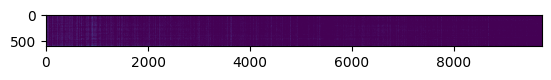

In [46]:
import matplotlib.pyplot as plt
import numpy as np
X = download_and_prepare('movielens-small', '/home/dearadhp/MRS/')
R = X
mask = (R > 0).astype(dtype='int8')
print(R.shape)
print(mask.shape)
Ro = mask*R
split = np.random.rand(mask.shape[0], mask.shape[1])
Train_l = int(np.floor(0.8*mask.shape[0]))
Test_l = int(mask.shape[0]-np.floor(0.8*mask.shape[0]))
wid = int(mask.shape[1])
lenth = int(mask.shape[0])
print(mask.shape[0]-np.floor(0.8*mask.shape[0]))
split_train = np.vstack((np.ones((Train_l,wid)),np.zeros((Test_l,wid))))
split_test = np.vstack((np.zeros((Train_l,wid)),np.ones((Test_l,wid))))
#R =(R- np.amin(R))/(np.amax(R)-np.amin(R))*255

mask_train = mask * (split_train).astype(dtype='int8')
mask_test = mask * (split_test).astype(dtype='int8')
print(sum(sum(mask-mask_test-mask_train)))
plt.figure()
plt.imshow(R)
plt.show()



In [5]:
# %load metrics.py
import numpy as np

def confusion_matrix(y_true, y_pred, normalize=None):
    """Computes the confusion matrix from predictions and labels.

    The matrix columns represent the real labels and the rows represent the
    prediction labels. The confusion matrix is always a 2-D array of shape `[n_labels, n_labels]`,
    where `n_labels` is the number of valid labels for a given classification task. Both
    prediction and labels must be 1-D arrays of the same shape in order for this
    function to work.

    Parameters:
        y_true: 1-D array of real labels for the classification task.
        y_pred: 1-D array of predictions for a given classification.
        normalize: One of ['true', 'pred', 'all', None], corresponding to column sum, row sum, matrix sum, or no
                   normalization.

    Returns:
        A 2-D array with shape `[n_labels, n_labels]` representing the confusion
        matrix, where `n` is the number of possible labels in the classification
        task.
    """

    if normalize not in ['true', 'pred', 'all', None]:
        raise ValueError("normalize must be one of {'true', 'pred', 'all', None}")

    n_labels = np.maximum(np.max(y_true), np.max(y_pred)) + 1

    cm = np.zeros((n_labels, n_labels))
    for i, j in zip(y_pred, y_true):
        cm[i, j] += 1

    if normalize == 'true':
        cm = cm / cm.sum(axis=0, keepdims=True)
    elif normalize == 'pred':
        cm = cm / cm.sum(axis=1, keepdims=True)
    elif normalize == 'all':
        cm = cm / cm.sum()

    return cm


def precision(y_true, y_pred):
    return confusion_matrix(y_true, y_pred, normalize='pred')[1, 1]


def recall(y_true, y_pred):
    return confusion_matrix(y_true, y_pred, normalize='true')[1, 1]


def false_alarm_rate(y_true, y_pred):
    return confusion_matrix(y_true, y_pred, normalize='true')[1, 0]


In [7]:
# %load recommender_system.py
import numpy as np

class MatrixFactorization(object):
    """Matrix factorization for movie recommendations.

    Parameters:
        R (ndarray): ratings matrix (0 for no ratings, 1-5 if a rating exists)
        factors (int): number of factors for matrix factorization
        steps (int): number of steps to perform during training
        lr (float): learning rate
    """
    def __init__(self, R, factors=5, steps=1000, lr=1e-4):
        self.R = R
        self.factors = factors
        self.steps = steps
        self.lr = lr

        # Generate mask for known entries (non-zero elements), split the mask into a train and test mask
        self.mask = (self.R > 0).astype(dtype='int8')
        self.split = np.random.rand(self.mask.shape[0], self.mask.shape[1])
        self.mask_train = self.mask * (self.split >= 0.2).astype(dtype='int8')
        self.mask_test = self.mask * (self.split < 0.2).astype(dtype='int8')
        print(f"Known entries: {self.mask.sum()}, {self.mask_train.sum()} used for training and {self.mask_test.sum()} used for testing.")

        # For sparse implementation
        self.nonzero_indices = np.argwhere(self.mask_train > 0)
        self.ilist = self.nonzero_indices[:, 0]
        self.jlist = self.nonzero_indices[:, 1]
        self.R_ijs = self.R[np.array(self.ilist), np.array(self.jlist)]

        # Initialize low-rank user and movie matrix uniformly between 0 and 1
        self.U = np.random.rand(self.R.shape[0], self.factors).astype(dtype='float32')
        self.V = np.random.rand(self.R.shape[1], self.factors).astype(dtype='float32')

        # Compute total amount of parameters that have to be estimated
        total_parameters = self.U.reshape(-1).size + self.V.reshape(-1).size
        print(f"User matrix shape: {self.U.shape}, movie matrix shape: {self.V.shape}, total parameters: {total_parameters}")

    def gradient_user_matrix(self, error):
        return -np.matmul(error, self.V)

    def gradient_movie_matrix(self, error):
        return -np.matmul(error.T, self.U)

    def update_user_matrix(self, u_grad):
        self.U = self.U - self.lr * u_grad

    def update_movie_matrix(self, v_grad):
        self.V = self.V - self.lr * v_grad

    def rmse(self, split='all'):
        if split == 'train':
            rmse = np.sqrt(np.sum(self.mask_train * (self.R - np.matmul(self.U, self.V.T)) ** 2) / np.sum(self.mask_train))
        elif split == 'test':
            rmse = np.sqrt(np.sum(self.mask_test * (self.R - np.matmul(self.U, self.V.T)) ** 2) / np.sum(self.mask_test))
        else:
            rmse = np.sqrt(np.sum(self.mask * (self.R - np.matmul(self.U, self.V.T)) ** 2) / np.sum(self.mask))
        return rmse

    def fit(self, sparse=True):
        for i in range(self.steps):

            if i % 100 == 0:
                print(f"Step {i}/{self.steps}, RMSE (train): {self.rmse('train'):.4f}, RMSE (test): {self.rmse('test'):.4f}")

            if sparse:
                U_is = self.U[np.array(self.ilist)]
                V_js = self.V[np.array(self.jlist)]
                errors = self.R_ijs - np.sum(U_is * V_js, axis=1)
                error_matrix = np.zeros_like(self.R)
                error_matrix[self.ilist, self.jlist] = errors
                self.U += self.lr * np.matmul(error_matrix, self.V)
                self.V += self.lr * np.matmul(error_matrix.T, self.U)

            else:
                error = self.mask_train * (self.R - self.mask_train * np.matmul(self.U, self.V.T)) # Compute the error outside the gradient computation, so we don't have to do it twice
                u_grad = self.gradient_user_matrix(error)
                v_grad = self.gradient_movie_matrix(error)
                self.update_user_matrix(u_grad)
                self.update_movie_matrix(v_grad)

        print(f"Step {self.steps}/{self.steps}, RMSE (train): {self.rmse('train'):.4f}, RMSE (test): {self.rmse('test'):.4f}")

        return np.matmul(self.U, self.V.T)


In [9]:
# %load main.py
import numpy as np

from metrics import confusion_matrix, precision, recall, false_alarm_rate
from datasets import download_and_prepare
from recommender_system import MatrixFactorization


def main():
    np.random.seed(42)
    np.set_printoptions(precision=2, floatmode='fixed')

    # Part I
    print("------------------------------------------------")
    print("Part I - Confusion matrix")
    print("------------------------------------------------")

    y_true = np.random.randint(0, 2, 20)
    y_pred = np.random.randint(0, 2, 20)

    print("Unnormalized confusion matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    print("Matrix sum normalization:")
    cm = confusion_matrix(y_true, y_pred, normalize='all')
    print(cm)
    print("Row sum normalization:")
    cm = confusion_matrix(y_true, y_pred, normalize='pred')
    print(cm)
    print("Column sum normalization:")
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    print(cm)
    print(f"Precision: {precision(y_true, y_pred):.2f}, recall: {recall(y_true, y_pred):.2f}"
          f", false alarm rate: {false_alarm_rate(y_true, y_pred):.2f}")

    # Part II
    print("------------------------------------------------")
    print("Part II - Movie Recommender System")
    print("------------------------------------------------")

    X = download_and_prepare('movielens-small', '../datasets')
    matrixFactor = MatrixFactorization(X)
    r_hat = matrixFactor.fit()

if __name__ == "__main__":
    main()


------------------------------------------------
Part I - Confusion matrix
------------------------------------------------
Unnormalized confusion matrix:
[[4.00 3.00]
 [9.00 4.00]]
Matrix sum normalization:
[[0.20 0.15]
 [0.45 0.20]]
Row sum normalization:
[[0.57 0.43]
 [0.69 0.31]]
Column sum normalization:
[[0.31 0.43]
 [0.69 0.57]]
Precision: 0.31, recall: 0.57, false alarm rate: 0.69
------------------------------------------------
Part II - Movie Recommender System
------------------------------------------------
Preparing dataset movielens-small...
Extracting dataset movielens-small...
100836 entries read.
Known entries: 100836, 80598 used for training and 20238 used for testing.
User matrix shape: (610, 5), movie matrix shape: (9724, 5), total parameters: 51670
Step 0/1000, RMSE (train): 2.5330, RMSE (test): 2.5469
Step 100/1000, RMSE (train): 1.0097, RMSE (test): 1.0598
Step 200/1000, RMSE (train): 0.8991, RMSE (test): 0.9681
Step 300/1000, RMSE (train): 0.8558, RMSE (test): 0